In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.signal
from scipy.signal import savgol_filter
# import plotly.graph_objects as go

In [2]:
coor_array=[]

long_coord = []
lat_coord = []

for i in range(2):
    long_coord.append(180*i)
for k in range(7):
    lat_coord.append(-15*k)

for lat in lat_coord:
    for long in long_coord:
        
        coor_array.append((long,lat))

In [3]:
width=np.load("widths.npy")

In [4]:
sample_data = np.asarray(np.genfromtxt('../GS4/GS4_Trace{}'.format(1), dtype=float,
                         delimiter="\t", autostrip=True,skip_header=1, names =True))
length=len(sample_data)
print(sample_data.shape)

(600,)


In [5]:
raw_data_array=np.empty([180,2,600])
for i in range(180):
    raw_data = np.genfromtxt('../GS4/GS4_Trace{}'.format(i), dtype=float,
    delimiter="\t", autostrip=True,skip_header=1, names =True)
    raw_x=np.array([pair[0] for pair in raw_data])
    raw_y=np.array([pair[1] for pair in raw_data])
    raw_data_array[i,0,:]=raw_x
    raw_data_array[i,1,:]=raw_y

print(np.mean(raw_data_array[0,:,:],axis=1))

# convert to micro-volt and MHz
raw_data_array[:,1,:]=1e6*raw_data_array[:,1,:]
raw_data_array[:,0,:]=raw_data_array[:,0,:]/1e6

print(np.mean(raw_data_array[0,:,:],axis=1))

[1.42040167e+09 1.77182407e-05]
[1420.40166667   17.71824068]


In [6]:
sample_vx=raw_data_array[0,0,:]
sample_vy=raw_data_array[0,1,:]

In [7]:
# check the data is what we want
binw = 0.000003333333
ntbin=(sample_vx[length-1]-sample_vx[0])/binw
ntbin=ntbin+1
print(ntbin)

599001.1599000507


# Finding proportionality constant from sun data

In [8]:
# Finding proportionality constant from sun data
sunAmp = 2.3133616383333307e-05
TSun = 100000
viewSRT = .016
viewSun = 6.8e-5
TempPropConstant = (sunAmp*viewSRT)/(TSun*viewSun)
P2T= TempPropConstant*1e9
print(P2T)

54.432038549019545


# Convert to velocity 

In [9]:
xx=raw_data_array[:,0,:]
vy=raw_data_array[:,1,:]

def get_velocity(frequency):
    return(3e5*(1-1420.4/frequency))
xv=get_velocity(xx)

In [10]:
def get_dBm(milvolt):
    volt=milvolt/1e6
    return(10.*np.log10(volt*volt*1000./50))

def get_power(milvolt):
    volt=milvolt/1e6
    return(1e12*volt*volt/50)

In [11]:
yV=vy
yD=get_dBm(vy)
yP=get_power(vy)

In [12]:
#set the errors
shape=xx.shape
xxerror=np.full(shape,0.0)
yVerror=np.full(shape,0.03)
yDerror=np.full(shape,0.03)
yPerror=np.full(shape,0.03)
yTerror=np.full(shape,2.0)

In [13]:
#delete sharp peaks
ymax=5.25
mult=1.10

start=3
end=length-3


def del_peak(yP_vector):
    yP=np.copy(yP_vector)
    for i in np.arange(start,end):
        ytmp=yP[i]
        ytmpM=yP[i-2]
        ytmpP=yP[i+2]
        yavg=(ytmpM+ytmpP)/2.0
        if ytmp < (mult*yavg):
            pass
        else:
            yP[i]=yavg
            yP[i-1]=yavg
            yP[i+1]=yavg
#     print(np.all(yP==yP_vector))
    return(yP)

In [14]:
def test_del_peak():
    for i in range(180):
        yP_vector=yP[i,:]
        diff=yP_vector-del_peak(yP_vector)
        if np.sum(diff)!=0:
            print("it's working")
            break
                
test_del_peak()

it's working


In [15]:
yP_no_peak=np.apply_along_axis(del_peak,1,yP)

In [16]:
xv[1,:][100:500]

array([-140.16676798, -139.46215504, -138.75754541, -138.05272768,
       -137.34812467, -136.64352496, -135.93871717, -135.23412408,
       -134.5295343 , -133.82473643, -133.12015326, -132.41557341,
       -131.71078547, -131.00621223, -130.3016423 , -129.59686429,
       -128.89230097, -128.18774097, -127.48297288, -126.7784195 ,
       -126.07386942, -125.36911126, -124.66456779, -123.96002764,
       -123.25527941, -122.55074587, -121.84621564, -121.14147733,
       -120.43695372, -119.73243341, -119.02770504, -118.32319135,
       -117.61868096, -116.91396251, -116.20945875, -115.50495829,
       -114.80024976, -114.09575592, -113.39126538, -112.68656679,
       -111.98208287, -111.27760225, -110.57291358, -109.86843959,
       -109.1639689 , -108.45929015, -107.75482608, -107.05036531,
       -106.34569649, -105.64124234, -104.9367915 , -104.2321326 ,
       -103.52768837, -102.82324745, -102.11859849, -101.41416418,
       -100.70973318, -100.00509414,  -99.30066975,  -98.59624

In [17]:
for i in np.arange(0):
    x=xv[i,:]
    y=yP_no_peak[i,:]
#     plt.axvline(width[i][0],color='r')
#     plt.axvline(width[i][1],color='r')
    plt.plot(x,y)
    plt.title(i)
    plt.show()


In [18]:
#delete the signal region and fit the spectrum with second degree polynomial.
def del_signal_and_fit(xv_vec,yP_vec,del_region=(-50,50)):
    x1del=del_region[0]
    x2del=del_region[1]
    xv=np.copy(xv_vec)
    yP_for_fit=np.copy(yP_vec)
    yP_original=np.copy(yP_vec)
    
    signal_region=(xv>x1del) &(xv<x2del)
    yP_for_fit[signal_region] = np.mean(yP_for_fit[~signal_region])
    
    z=np.polyfit(xv,yP_for_fit,2)
    p=np.poly1d(z)
#     print(yP)
    
#     for i in range(length):
#         xtmp=xv[i]
        
#         if (xtmp > x1del and xtmp < x2del):
#             XB[npoint]=xtmp
#             YB[npoint]=
#             npoint=npoint+1
#         else:
#             XB[npoint]=xtmp
#             YB[npoint]=yP[i]
#             npoint=npoint+1

#     plt.plot(xv,yP_for_fit)
#     plt.plot(xv,p(xv))
    fit=p(xv)
    YP=yP_original-fit
#     plt.plot(xv,YP)
    plt.show()
    return(YP)

In [19]:
subtracted_yP=np.empty([90,length])

for i in range(90):
    subtracted_yP[i,:]=del_signal_and_fit(xv[i,:],yP_no_peak[i,:],tuple(width[i]))

In [20]:
def rebinning(xv_vec,yP_vec):
    xv_rebinned=np.empty(int(length/6))
    yP_rebinned=np.empty(int(length/6))
    for i in np.arange(0,length,6):
        xv_rebinned[int(i/6)]=np.mean(xv_vec[i:i+6])
        yP_rebinned[int(i/6)]=np.mean(yP_vec[i:i+6])
    return(xv_rebinned,yP_rebinned)

[  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138 144 150 156 162 168 174 180 186 192 198 204 210
 216 222 228 234 240 246 252 258 264 270 276 282 288 294 300 306 312 318
 324 330 336 342 348 354 360 366 372 378 384 390 396 402 408 414 420 426
 432 438 444 450 456 462 468 474 480 486 492 498 504 510 516 522 528 534
 540 546 552 558 564 570 576 582 588 594]


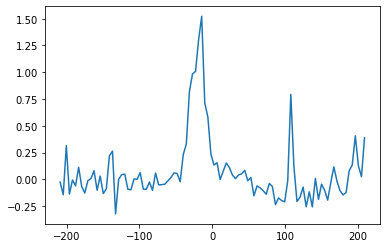

In [21]:
print(np.arange(0,length,6))
x,y=rebinning(xv[1,:],subtracted_yP[1,:])
plt.plot(x,y)

In [22]:
xv.shape
xv_rebinned=np.empty([90,100])
yP_sub_rebinned=np.empty([90,100])
for i in range(90):
    x,y=x,y=rebinning(xv[i,:],subtracted_yP[i,:])
    xv_rebinned[i,:]=x
    yP_sub_rebinned[i,:]=y

In [23]:
test=xv[1,:]
test.shape
print(length/6)
print(np.arange(0,length-6,6))

100.0
[  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138 144 150 156 162 168 174 180 186 192 198 204 210
 216 222 228 234 240 246 252 258 264 270 276 282 288 294 300 306 312 318
 324 330 336 342 348 354 360 366 372 378 384 390 396 402 408 414 420 426
 432 438 444 450 456 462 468 474 480 486 492 498 504 510 516 522 528 534
 540 546 552 558 564 570 576 582 588]


In [25]:
speedData= [(-53, 7), (-51, 7), (-52, 8), (-54, 7), (-54, 8), (-54, 6), (-59, 9), (-54, 16), (-67, 12), (-61, 7), (-59, 10), (-61, 10), (-60, 10), (-75, 15), (-65, 15), (-65, 17), (-82, 20), (-65, 10), (-61, 12), (-69, 12), (-65, 15), (-70, 15), (-77, 14), (-89, 19), (-114, 15), (-122, 18), (-112, 15), (-114, 15), (-134, 20), (-114, 17), (-122, 15), (-123, 14), (-128, 17), (-120, 13), (-133, 15), (-113, 10), (-120, 20), (-116, 13), (-105, 7), (-110, 15), (-114, 14), (-124, 20), (-101, 17), (-118, 22), (-92, 20), (-93, 10), (-92, 12), (-90, 10), (-90, 9), (-90, 15), (-88, 7), (-85, 13), (-83, 15), (-78, 10), (-73, 10), (-75, 10), (-70, 12), (-73, 14), (-61, 13), (-57, 10), (-55, 18), (-56, 8), (-48, 13), (-50, 13), (-54, 15), (-40, 15), (-42, 14), (-45, 10), (-37, 10), (-36, 12), (-35, 10), (-31, 12), (-29, 14), (-29, 17), (-29, 10), (-29, 12), (-27, 9), (-27, 10), (-29, 10), (-27, 15), (-25, 5), (-25, 8), (-24, 8), (-22, 8), (-22, 12), (-18, 10), (-21, 10), (-18, 10), (-19, 15), (-13, 10)]
len(speedData)
np.save('speedData0to90', speedData)

In [26]:
redshift = np.load('earth_redshift.npy').flatten()
redshiftA = redshift[180:270]


In [27]:
## ANALYZE SPEED DATA TO MAKE G CURVE

dR = (8.2*1000)*np.cos(long)*(.0026)#**2


speed_array =[]
error_array =[]
long = np.arange(0,90)
for i in range(90):
    speed = -speedData[i][0]
    error = speedData[i][1]
    speed_array.append(speed)
    error_array.append(error)
v_array =[]


vLSR = []
radius = 8.5*np.sin(long*np.pi/180)

# add correction for angular velocity
vCor=[None]*90
for i in range(90):
    vCor[i] =  220*np.sin(i*np.pi/180)
vCor=np.array(vCor)
v_array=np.array(speed_array)+vCor - redshiftA

plt.figure(1, figsize = (5,10), dpi = 300)
plt.title('Rotational Velocity vs. Galactic Radius', fontsize = 10)
plt.xlabel('Radius [kpc]', fontsize = 5)
plt.ylabel('Velocity [km/s]', fontsize = 5)
plt.xticks(np.arange(0,9, step =0.5), fontsize = 5)
plt.yticks(fontsize = 6)
plt.xlim(xmin = 0.0)
plt.ylim(0,300)
plt.errorbar(radius, v_array, yerr = error_array, xerr = dR/1000, fmt='o', linestyle="None", capsize = 2, capthick = .2, elinewidth = .2, ms = 1)
plt.show()

In [33]:
## Error propogation:

G = 4.302e-3 # [pc*solar^-1*(km/s)^2]
dM = np.sqrt(((2*v_array*(radius*1000)/G)*(error_array))**2 + ((v_array**2/G)*dR)**2)

# Mass Distribution
# m = v^2R/G


#Returns mass in solar units 
mass = (v_array**2)*(radius*1000)/G 

plt.figure(2, figsize = (5,5), dpi = 300)
plt.title('Mass Distribution of the Milky Way', fontsize = 10)
plt.xlabel('Radius [kpc]', fontsize = 5)
plt.ylabel('Mass [solar units]', fontsize = 5)
plt.xticks(np.arange(0,9, step =0.5), fontsize = 5)
plt.yticks(fontsize = 6)
plt.xlim(xmin = 0.0)
plt.ylim(0,1.3e11)
plt.errorbar(radius, mass, yerr = dM, xerr = dR/1000, fmt='o', linestyle="None", capsize = 2, capthick = .2, elinewidth = .2, ms = 1)
plt.show()

In [34]:
## Error propogation:

dR = (8.2)*np.cos(long)*(.0026)**2

dM = np.sqrt(2*v_array*(radius*1000)/G + (v_array**2/G)*dR)